# DB SCAN #

El agrupamiento espacial basado en densidad de aplicaciones con ruido o **Density-based spatial clustering of applications with noise (DBSCAN)** es un algoritmo de agrupamiento de datos (data clustering) propuesto por Martin Ester, Hans-Peter Kriegel, Jörg Sander y Xiaowei Xu en 1996.

Es un algoritmo de agrupamiento basado en densidad (density-based clustering) porque encuentra un número de grupos (clusters) comenzando por una estimación de la distribución de densidad de los nodos correspondientes.
Se basa en el concepto de densidad de cluster e intenta agrupar los puntos que estan más juntos.


Funciona mejor que K-Medias para geometrías más complejas

![img](https://miro.medium.com/max/1339/0*xu3GYMsWu9QiKNOo.png)

Precisa de 2 hiperparámetros:

- **MinPts** : mínimo de puntos alrededor de un punto para considerarlo un núcleo
- **Ɛ (eps)** : el radio alrededor de cada punto para considerar puntos cercanos

DB Scan define 3 tipos de puntos:

- **Núcleos (core points)** : aquellos puntos que tienen un número de puntos igual o mayor que **MinPts** en un radio de **Ɛ** alrededor

- **Alcanzables(reachable points)** : Aquellos puntos que no son núcleos pero que tienen un núcleo dentro de su radio **Ɛ**

- **Ruido (noise)** : Aquellos puntos que no son ni núcleos ni puntos alcanzables.

ALGORITMO

1.  Encontrar los vecinos de cada punto en su radio **Ɛ (eps)** , e identificar como núcleos aquellos con más vecinos que min Pts.


2.  Agrupar aquellos núcleos que esten a distancia **Ɛ (eps)** o menos, considerandolos parte del mismo cluster  


3.  Asignar a cada punto que no sea núcleo un cluster cercano si el cluster es vecino del punto. Aquellos puntos que no tengan ningún cluster cercano se consideran ruido.


### VENTAJAS E INCONVENIENTES

VENTAJAS:

* DBScan no precisa indicarle el número de clusters a buscar cómo hiperparámetro
* Al usar el criterio de densidad de puntos (y no distancias a un centro geométrico), DBScan es capaz de encontrar clusters que tengan formas complejas
* DBScan es robusto a outliers
* DBScan está diseñado para funcionar de forma óptima en bases de datos

DESVENTAJAS:

* DBScan no es determinista, y los resultados pueden variar según el orden en el que se evalúen las observaciones para aquellos puntos que estén a distancia de dos o más núcleos. Existe una versión renovada del algoritmo **HDBSCAN*** que evita esto

## PRÁCTICA ##

In [53]:
%load_ext watermark
%watermark

Last updated: 2021-02-16T00:03:54.861169+01:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 24 Stepping 1, AuthenticAMD
CPU cores   : 8
Architecture: 64bit



In [54]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 12]
np.random.seed(42)

In [55]:
from sklearn.datasets import make_blobs

In [56]:
K = 3
n_muestras = 5000

centroides = [(24, 30), (52, 35), (35, 60)]
X, clases_reales = make_blobs(n_samples=n_muestras, n_features=2, cluster_std=5.0,
                  centers=centroides, shuffle=False, random_state=42)

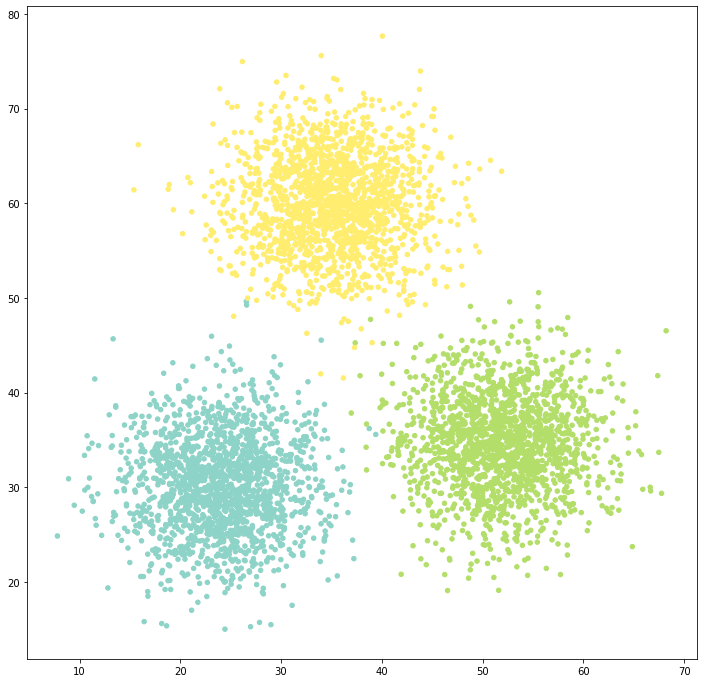

In [57]:
from matplotlib  import cm

plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3); #CMAP -> Paletas de color

In [58]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

In [59]:
estimador_kmedias = KMeans(n_clusters=3)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

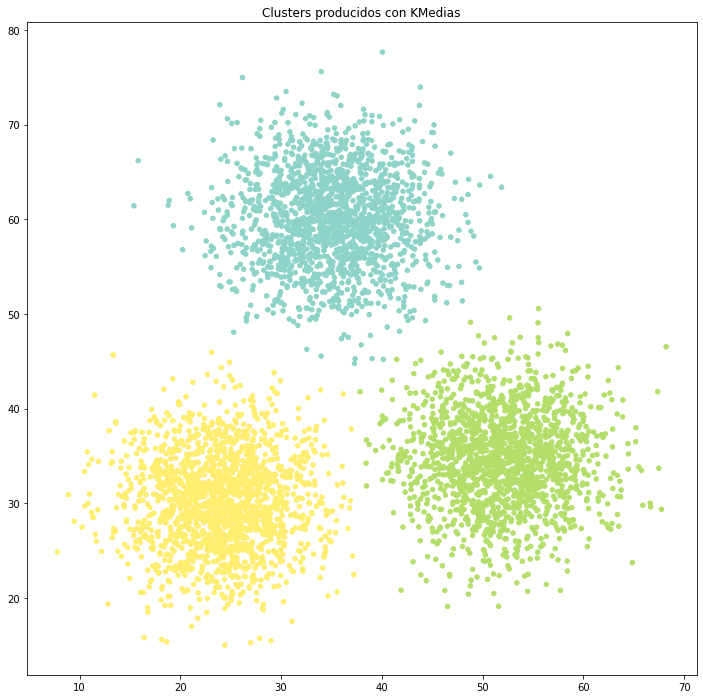

In [60]:
plt.scatter(X[:,0],X[:,1], c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias");

Dado que en este ejemplo, tenemos las clases verdaderas (ya que hemos generado el dataset de forma artificial), vamos a hacer unas funciones auxiliares que nos ayuden a mostrar de forma clara aquellos puntos que se clasifican de forma incorrecta.

En primer lugar, creamos una función que nos calcule el Índice de Jaccard de dos grupos de puntos (definido como el número de elementos comunes a los dos grupos (intersección) de los dos grupos dividida por el número de elementos en cualquiera de los dos grupos (la unión).

In [61]:
def jaccard_index(cluster1, cluster2):
   
    intersection = np.intersect1d(cluster1, cluster2).shape[0]
    union = np.union1d(cluster1, cluster2).shape[0]
    return intersection / union

In [62]:
jaccard_index(X[clases_reales==0], X[etiquetas_kmedias==0])

0.0008998200359928015

Ahora hacemos una funcion, que dado un conjunto de clases y clusters, nos diga que cluster se corresponde a cada clase. Esto es necesario ya que los nombres que da el estimador de clustering no tienen por qué coincidir con las clases reales (es decir, la clase `0` no tiene que representar al mismo número de puntos que el cluster `0`).

In [63]:
from itertools import product

In [64]:
list(product([1,2],[3,4]))

[(1, 3), (1, 4), (2, 3), (2, 4)]

In [65]:
def emparejar_clusters_clases(clusters, clases):
    combinaciones = product(np.unique(clases), np.unique(clusters))
    emparejamientos = {}
    class_ids = np.unique(clases)
    cluster_ids = np.unique(clusters)
    for cluster_id in cluster_ids:
        old_jaccard = 0
        for class_id in class_ids:
            new_jaccard = jaccard_index(X[clases==class_id], X[clusters==cluster_id])
            if new_jaccard > old_jaccard:
                old_jaccard = new_jaccard
                emparejamientos[cluster_id] = class_id
                if new_jaccard>=0.5:
                    break
    return emparejamientos

In [66]:
emparejar_clusters_clases(etiquetas_kmedias, clases_reales)

{0: 2, 1: 1, 2: 0}

Con estas funciones podemos crear una función auxiliar que nos transforma unas etiquetas de cluster para que se correspondan con las clases reales, y una función que nos devuelva aquellas observaciones cuya clase no coincida con el cluster 

In [67]:
def alinear_clusters(clusters, clases):
    reemplazos = emparejar_clusters_clases(clusters, clases)
    clusters_alineados = [reemplazos[x] for x in clusters]
    return np.array(clusters_alineados)

def encontrar_errores(clusters, clases):
    etiquetas_clusters_alineadas = alinear_clusters(clusters, clases)
    return X[clases!=etiquetas_clusters_alineadas]

Ahora podemos visualizar los puntos mal agrupados

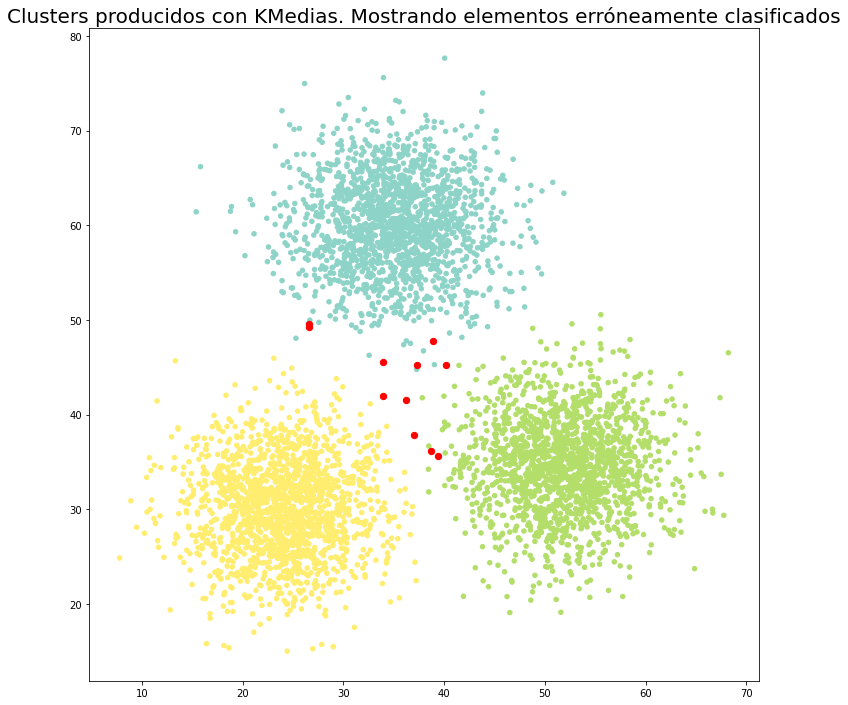

In [68]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20);

In [69]:
silhouette_score(X, etiquetas_kmedias)

0.6801855780824735

In [70]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(0.9848477175260213, 0.9848485778151886, 0.9848481476704171)

In [71]:
estimador_dbscan = DBSCAN(eps=10, min_samples=1000)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [72]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1,  2], dtype=int64)

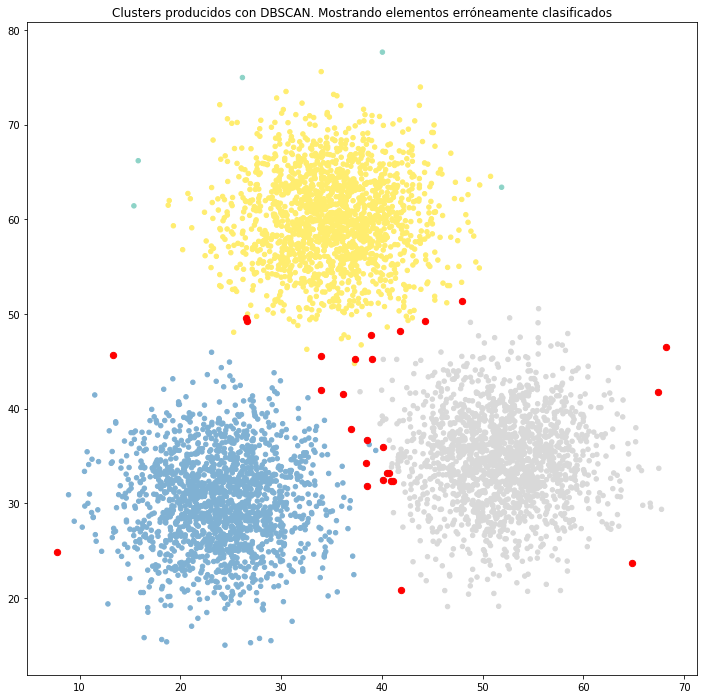

In [73]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

In [74]:
silhouette_score(X, etiquetas_dbscan)

0.6723834492118366

In [75]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9720560210205188, 0.9604880908580997, 0.9662374339590347)

Vemos que para el caso de tres clusters claramente definidos, KMedias funciona ligeramente mejor que DBSCAN

Probamos ahora con una distribución de datos que no sean tan fáciles de separar en grupos basándose en criterios geométricos.

In [76]:
from sklearn.datasets import make_circles

La función `make_circles` como su nombre indica, genera un dataset bidimensional en la forma de dos círculos concéntricos

In [77]:
X, clases_reales = make_circles(n_samples=5000, factor=.3, noise=.05)

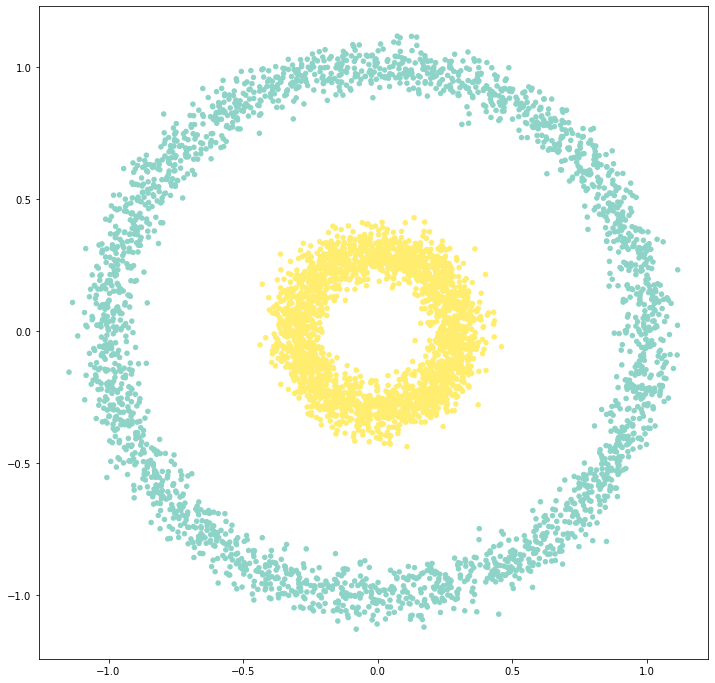

In [78]:
plt.scatter(X[:,0],X[:,1],c=clases_reales,s=20, marker = 'o', cmap=cm.Set3);

In [79]:
estimador_kmedias = KMeans(n_clusters=2)
etiquetas_kmedias = estimador_kmedias.fit(X).labels_

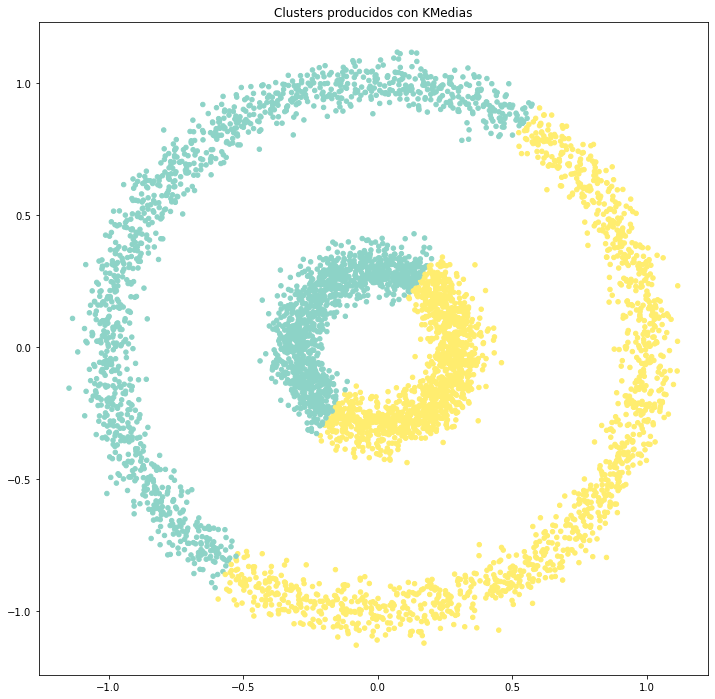

In [80]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.title("Clusters producidos con KMedias");

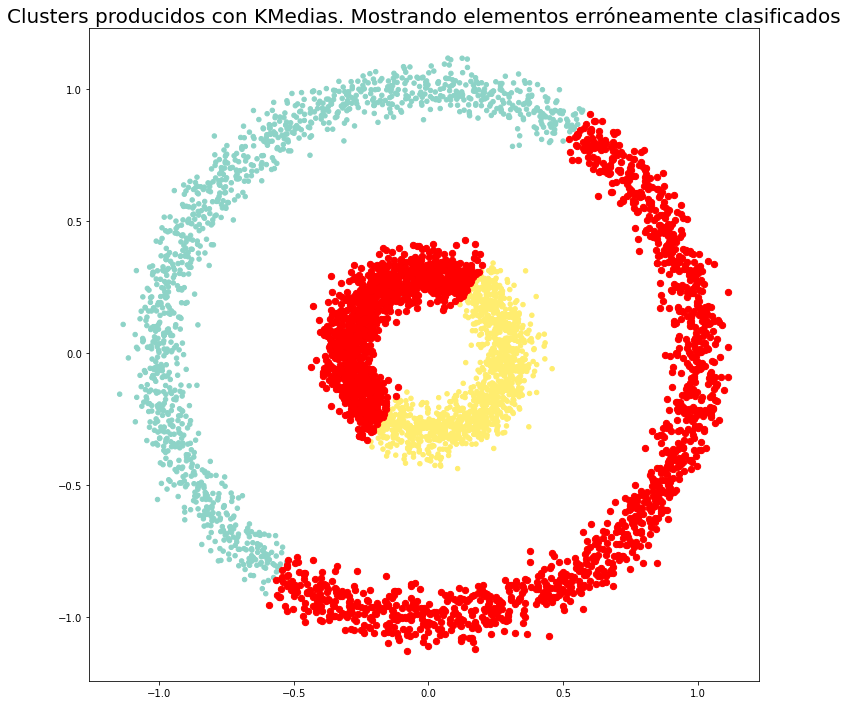

In [81]:
errores_kmedias = encontrar_errores(etiquetas_kmedias, clases_reales)
plt.scatter(X[:,0],X[:,1],c=etiquetas_kmedias,s=20, marker = 'o', cmap=cm.Set3)
plt.scatter(errores_kmedias[:,0],errores_kmedias[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con KMedias. Mostrando elementos erróneamente clasificados", size=20);

Vemos que KMedias agrupa de forma incorrecta la mitad de los puntos

In [82]:
silhouette_score(X, etiquetas_kmedias)

0.2963091045707866

In [83]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_kmedias)

(0.00014143058057794724, 0.0001414607702830852, 0.00014144567381961807)

Veamos ahora que tal funciona DBSCAN con este dataset

In [84]:
estimador_dbscan = DBSCAN(eps=0.05, min_samples=10)
etiquetas_dbscan = estimador_dbscan.fit(X).labels_

In [85]:
np.unique(etiquetas_dbscan)

array([-1,  0,  1], dtype=int64)

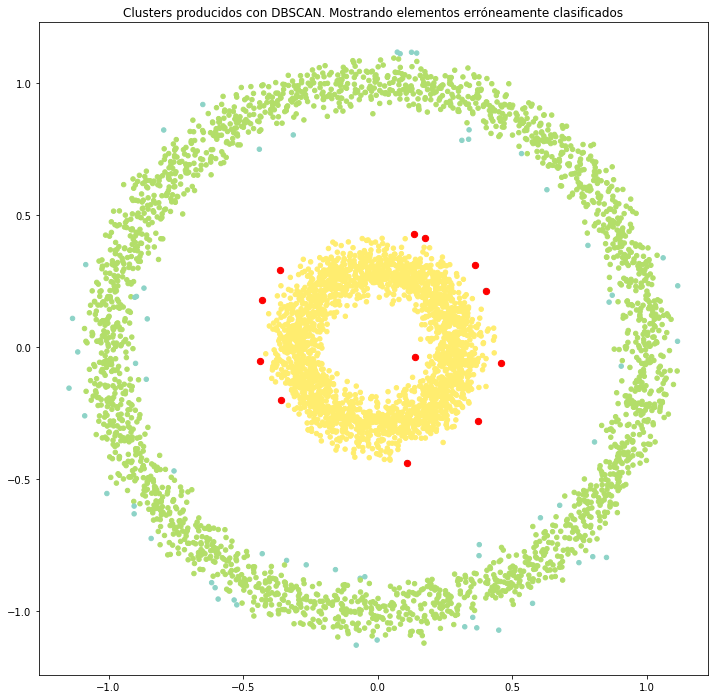

In [86]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_dbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_dbscan = encontrar_errores(etiquetas_dbscan, clases_reales)
plt.scatter(errores_dbscan[:,0],errores_dbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con DBSCAN. Mostrando elementos erróneamente clasificados");

Vemos que al basarse en un criterio de densidad, DBSCAN encuentra los clusters fácilmente.

In [87]:
silhouette_score(X, etiquetas_dbscan)

0.1900926718867449

In [88]:
homogeneity_completeness_v_measure(clases_reales, etiquetas_dbscan)

(0.9905360344392194, 0.9035444787298063, 0.9450425773116073)

En este caso he obtenido los hiperparámetros `eps=0.05, min_samples=10` a ojo, iterando sobre el gráfico para ver que valores separaban correctamente las clases reales. En general haríamos una optimización de hiperparámetros para obtener los valores que mejor funcionen.

In [89]:
estimador_dbscan.predict

AttributeError: 'DBSCAN' object has no attribute 'predict'

Una desventaja del estimador DBSCAN en ´sklearn´ es que no tiene el método predict. Es decir, no puede asignar clusters a nuevos puntos sin tener que ajustar el estimador desde cero.

## HDBSCAN* ##

HDBSCAN\* es la version actualizada del algoritmo DBSCAN (el original es de 1996, la actualización se publicó en 2015). Está disponible como contribución de scikit-learn en el paquete `hdbscan`

In [90]:
import sys

#!conda install --yes --prefix {sys.prefix} -c conda-forge hdbscan

Solving environment: ...working... done

# All requested packages already installed.



In [91]:
from hdbscan import HDBSCAN

In [92]:
print(HDBSCAN.__doc__)

Perform HDBSCAN clustering from vector array or distance matrix.

    HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications
    with Noise. Performs DBSCAN over varying epsilon values and integrates
    the result to find a clustering that gives the best stability over epsilon.
    This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN),
    and be more robust to parameter selection.

    Parameters
    ----------
    min_cluster_size : int, optional (default=5)
        The minimum size of clusters; single linkage splits that contain
        fewer points than this will be considered points "falling out" of a
        cluster rather than a cluster splitting into two new clusters.

    min_samples : int, optional (default=None)
        The number of samples in a neighbourhood for a point to be
        considered a core point.

    metric : string, or callable, optional (default='euclidean')
        The metric to use when calculating distance between ins

In [93]:
estimador_hdbscan = HDBSCAN()
etiquetas_hdbscan = estimador_hdbscan.fit_predict(X)

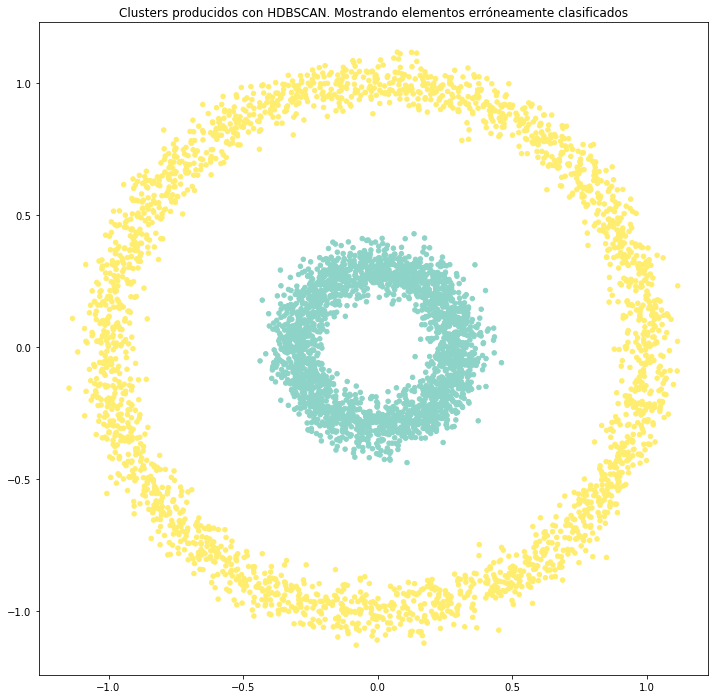

In [94]:
plt.scatter(X[:,0],X[:,1],c=etiquetas_hdbscan,s=20, marker = 'o', cmap=cm.Set3)
errores_hdbscan = encontrar_errores(etiquetas_hdbscan, clases_reales)
plt.scatter(errores_hdbscan[:,0],errores_hdbscan[:,1],s=40, marker = 'o', color="red")

plt.title("Clusters producidos con HDBSCAN. Mostrando elementos erróneamente clasificados");

Vemos que HDBSCAN agrupa de forma perfecta las dos clases

Al contrario que DBSCAN, la implementacion de `hdbscan` tiene un metodo `approximate_predict` que una vez ajustado permite asignar clusters a nuevos puntos sin tener que realizar todo el proceso desde cero.